In [48]:
import os
import pandas as pd
import sys
import numpy as np
import seaborn as sns

In [2]:
for i in range(1, 5):
    fp = os.path.join("outputs/test", str(i), "progress.csv")
    df = pd.read_csv(fp)
    print(max(df["V_Accuracy"]))

0.8946731234866828
0.8595641646489104
0.851089588377724
0.837772397094431


In [4]:
from src.train.config import Config as ModelConfig
from src.models.pct.point_transformer_cls import get_model as get_pct, get_loss as get_pct_loss
from src.models.pt.model import get_model as get_pt, get_loss as get_pt_loss


def get_model(model_name, method, num_points, num_class, input_dim, init_hidden_dim, k, device):
    model_config = ModelConfig(method, num_points, num_class, input_dim, init_hidden_dim, k)
    if model_name == "pct":
        model = get_pct(model_config).float().to(device)
        loss_fn = get_pct_loss()
    elif model_name == "pt":
        model = get_pt(model_config).float().to(device)
        loss_fn = get_pt_loss()
    else:
        raise ValueError(f"The provided model_name is not supported: {model_name}")
    
    return model, loss_fn

ModuleNotFoundError: No module named 'fps_knn_pct'

In [30]:
sys.path.append('src/train')

import torch
import torchvision.models as models
from ptflops import get_model_complexity_info
from train_model import get_model

model, _ = get_model(
    "pct", 
    "random", 
    1024,
    40,
    3,
    64,
    32,  
    "mps"
)

input_tensor = torch.rand(32, 1024, 3).to("mps")
flops, params = get_model_complexity_info(model, (1024, 3), as_strings=True, print_per_layer_stat=True)

print('FLOPs:', flops)
print('Parameters:', params)

PCT(
  2.82 M, 102.381% Params, 557.79 MMac, 99.836% MACs, 
  (conv1): Conv1d(192, 0.007% Params, 196.61 KMac, 0.035% MACs, 3, 64, kernel_size=(1,), stride=(1,), bias=False)
  (conv2): Conv1d(4.1 k, 0.149% Params, 4.19 MMac, 0.751% MACs, 64, 64, kernel_size=(1,), stride=(1,), bias=False)
  (bn1): BatchNorm1d(128, 0.005% Params, 131.07 KMac, 0.023% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, 0.005% Params, 131.07 KMac, 0.023% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (random_subsample1): Random_Subsample_Feature(
    8.45 k, 0.307% Params, 4.39 MMac, 0.786% MACs, 
    (conv): Conv1d(8.19 k, 0.298% Params, 4.19 MMac, 0.751% MACs, 64, 128, kernel_size=(1,), stride=(1,), bias=False)
    (bn): BatchNorm1d(256, 0.009% Params, 131.07 KMac, 0.023% MACs, 128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(0, 0.000% Params, 65.54 KMac, 0.012% MACs, )
  )
  (random_subsample

In [72]:
model, _ = get_model(
    "pt", 
    "tome_xyz", 
    1024,
    40,
    3,
    32,
    16,  
    "mps"
)

input_tensor = torch.rand(32, 1024, 3).to("mps")
flops, params = get_model_complexity_info(model, (1024, 3), as_strings=True, print_per_layer_stat=True)

# print('FLOPs:', flops)
# print('Parameters:', params)

print(flops)

PointTransformerCls(
  7.91 M, 100.000% Params, 2.79 GMac, 99.921% MACs, 
  (backbone): Backbone(
    7.76 M, 98.098% Params, 2.79 GMac, 99.916% MACs, 
    (fc1): Sequential(
      1.18 k, 0.015% Params, 1.25 MMac, 0.045% MACs, 
      (0): Linear(128, 0.002% Params, 131.07 KMac, 0.005% MACs, in_features=3, out_features=32, bias=True)
      (1): ReLU(0, 0.000% Params, 32.77 KMac, 0.001% MACs, )
      (2): Linear(1.06 k, 0.013% Params, 1.08 MMac, 0.039% MACs, in_features=32, out_features=32, bias=True)
    )
    (transformer1): MyAttention2(
      1.35 M, 17.014% Params, 1.38 GMac, 49.347% MACs, 
      (fc1): Linear(16.9 k, 0.214% Params, 17.3 MMac, 0.620% MACs, in_features=32, out_features=512, bias=True)
      (fc2): Linear(16.42 k, 0.208% Params, 16.81 MMac, 0.602% MACs, in_features=512, out_features=32, bias=True)
      (fc_gamma): Sequential(
        525.31 k, 6.645% Params, 538.44 MMac, 19.284% MACs, 
        (0): Linear(262.66 k, 3.322% Params, 268.96 MMac, 9.633% MACs, in_feature

In [38]:
import time

time_dict = dict()

for model_name in ["pct", "pt"]:
    time_dict[model_name] = dict()

    if model_name == "pct":
        hidden_size = 64
        k = 32
    else:
        hidden_size = 32
        k = 16

    for strat in ["normal", "tome_ft", "tome_xyz", "random"]:
        model, _ = get_model(
            model_name, 
            strat, 
            1024,
            40,
            3,
            hidden_size,
            k,  
            "mps"
        )

        N = 5
        times = list()
        for i in range(N):
            input = torch.rand(32, 1024, 3).to("mps")
            start = time.time()
            model(input)
            end = time.time()
            times.append(end - start)

        times = np.array(times)
        time_dict[model_name][strat] = times
            

[Text(0.5, 0, 'strategy'), Text(0, 0.5, 'time (seconds)')]

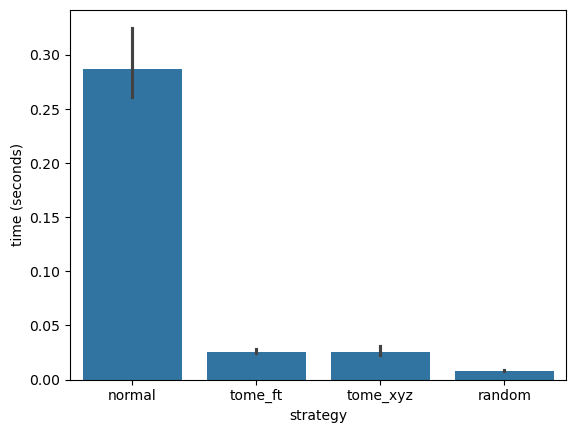

In [57]:
melted = pd.DataFrame(time_dict).reset_index().melt(id_vars = 'index').explode(column='value').reset_index(drop=True)
melted 
ax = sns.barplot(melted[melted['variable'] == 'pct'],x='index',y='value')
ax.set(xlabel='strategy', ylabel='time (seconds)')

[Text(0.5, 0, 'strategy'), Text(0, 0.5, 'time (seconds)')]

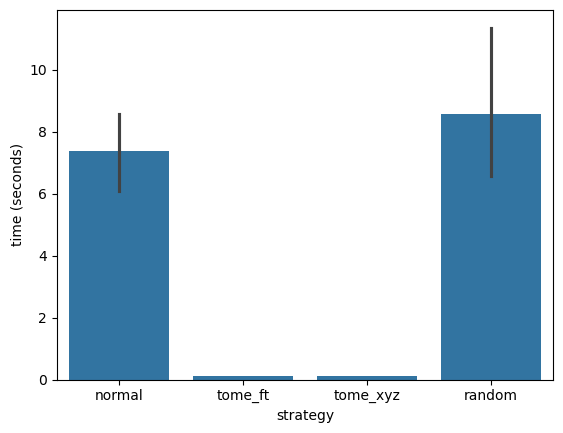

In [59]:
ax = sns.barplot(melted[melted['variable'] == 'pt'],x='index',y='value')
ax.set(xlabel='strategy', ylabel='time (seconds)')